In [16]:
import numpy as np
import torch.nn as nn
from torch.nn import parameter
import torch.nn.functional as F
import torch.optim as optimizer
from torch.nn.init import xavier_uniform_
import torch
import gym
from scipy.signal import lfilter

def xavier(param):
    xavier_uniform_(param)

def weights_init(m):
    if isinstance(m, nn.Linear):
        xavier(m.weight.data)
        m.bias.data.zero_()

!pip install livelossplot --quiet
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np

In [7]:
class ParameterisedPolicyNetwork(nn.Module):

    def __init__(self, state_space_cardinality, action_space_cardinality):
        super().__init__()
        self.input_fc = nn.Linear(in_features=state_space_cardinality, out_features=64)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(
            in_features=64, out_features=action_space_cardinality)

        self.input_fc.apply(weights_init)
        self.output_fc.apply(weights_init)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.relu(x)
        x = F.softmax(self.output_fc(x))  

        return x

class ParameterisedValueFunctionNetwork(nn.Module):

    def __init__(self, state_space_cardinality) -> None:
        super().__init__()
        self.input_fc = nn.Linear(in_features=state_space_cardinality, out_features=64)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(in_features=64, out_features=1)

        self.input_fc.apply(weights_init)
        self.output_fc.apply(weights_init)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.relu(x)
        x = self.output_fc(x)

        return x

In [8]:
def determine_action(S_t, parameterised_policy, action_space_cardinality):
    parameterised_policy.eval()
    pi_given_S = parameterised_policy(torch.tensor(S_t).float()).cpu().detach().numpy()
    
    A_t = np.random.choice(action_space_cardinality, p=pi_given_S)
    return A_t

In [9]:
def update_w(delta, optimizer_w, parameterised_value_func, S_t):
    parameterised_value_func.train()
    optimizer_w.zero_grad()
    loss_value = torch.sum( (torch.FloatTensor(delta) * parameterised_value_func(torch.FloatTensor(S_t)))) # delta is just a constant that can be multiplied
    loss_value.backward()
    optimizer_w.step()
    return loss_value.data.item()

def update_theta(delta, optimizer_theta, parameterised_policy, A_t, S_t, gamma,  I=None):
    parameterised_policy.train()
    optimizer_theta.zero_grad()
    pi_given_S = parameterised_policy(torch.FloatTensor(S_t))
    loss_policy = -torch.sum( (I* torch.FloatTensor(delta)* torch.log(pi_given_S[A_t])))
    loss_policy.backward()
    optimizer_theta.step()
    return loss_policy.data.item()

In [28]:
def one_step_actor_critic(alpha_w, alpha_theta, gamma, env, episodes):
    state_space_cardinality = env.observation_space.shape[0]
    action_space_cardinality = env.action_space.n
    parameterised_policy = ParameterisedPolicyNetwork(state_space_cardinality=state_space_cardinality, action_space_cardinality=action_space_cardinality)
    parameterised_value_func = ParameterisedValueFunctionNetwork(state_space_cardinality=state_space_cardinality)

    optimizer_theta = optimizer.Adam( parameterised_policy.parameters(), lr=alpha_theta)
    optimizer_w = optimizer.Adam( parameterised_value_func.parameters(), lr=alpha_w)
    scheduler_theta = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_theta, T_max=episodes)
    scheduler_w = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_w, T_max=episodes)

    accumulated_rewards = []
    liveloss = PlotLosses()
    
    for episode in range(episodes):
        S_t = env.reset()
        I = 1
        accumulated_reward = 0
        logs = {}
        loss_w = 0.0
        loss_theta = 0.0
        
        while True:
            A_t = determine_action(S_t, parameterised_policy, action_space_cardinality)
            S_t_next, R_t, terminal, _ = env.step(A_t)
            accumulated_reward += R_t

            parameterised_value_func.eval()
            # print('reward at time step t is:', R_t)
            if not terminal:
                delta = R_t + gamma*parameterised_value_func(torch.FloatTensor(S_t_next)).detach().numpy() - parameterised_value_func(torch.FloatTensor(S_t)).detach().numpy() 
            else:
                delta = R_t + parameterised_value_func(torch.FloatTensor(S_t)).detach().numpy()
            loss_w     += update_w(delta, optimizer_w, parameterised_value_func, S_t)#, actor_critic= True, I=I)
            loss_theta += update_theta(delta, optimizer_theta, parameterised_policy, A_t, S_t, gamma, I=I)

            scheduler_theta.step()
            scheduler_w.step()
            if terminal:
                break
            I *= gamma
            S_t = S_t_next
            
        accumulated_rewards.append(accumulated_reward)
        print("EPISODE: {}, SUM OF REWARDS: {}, ACC SUM REWS {}".format(
            episode, accumulated_reward, np.mean(accumulated_rewards)))
    return accumulated_rewards

2e-14
EPISODE: 0, SUM OF REWARDS: 15.0, ACC SUM REWS 15.0
EPISODE: 1, SUM OF REWARDS: 46.0, ACC SUM REWS 30.5
EPISODE: 2, SUM OF REWARDS: 10.0, ACC SUM REWS 23.666666666666668
EPISODE: 3, SUM OF REWARDS: 14.0, ACC SUM REWS 21.25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 4, SUM OF REWARDS: 15.0, ACC SUM REWS 20.0
EPISODE: 5, SUM OF REWARDS: 16.0, ACC SUM REWS 19.333333333333332
EPISODE: 6, SUM OF REWARDS: 12.0, ACC SUM REWS 18.285714285714285
EPISODE: 7, SUM OF REWARDS: 10.0, ACC SUM REWS 17.25
EPISODE: 8, SUM OF REWARDS: 11.0, ACC SUM REWS 16.555555555555557
EPISODE: 9, SUM OF REWARDS: 12.0, ACC SUM REWS 16.1
EPISODE: 10, SUM OF REWARDS: 10.0, ACC SUM REWS 15.545454545454545
EPISODE: 11, SUM OF REWARDS: 11.0, ACC SUM REWS 15.166666666666666
EPISODE: 12, SUM OF REWARDS: 8.0, ACC SUM REWS 14.615384615384615
EPISODE: 13, SUM OF REWARDS: 9.0, ACC SUM REWS 14.214285714285714
EPISODE: 14, SUM OF REWARDS: 10.0, ACC SUM REWS 13.933333333333334
EPISODE: 15, SUM OF REWARDS: 12.0, ACC SUM REWS 13.8125
EPISODE: 16, SUM OF REWARDS: 9.0, ACC SUM REWS 13.529411764705882
EPISODE: 17, SUM OF REWARDS: 10.0, ACC SUM REWS 13.333333333333334
EPISODE: 18, SUM OF REWARDS: 9.0, ACC SUM REWS 13.105263157894736
EPISODE: 19, SUM OF REWARDS: 9.0, ACC SUM REWS 12.9
EPISO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: 15.0, ACC SUM REWS 15.0
EPISODE: 1, SUM OF REWARDS: 25.0, ACC SUM REWS 20.0
EPISODE: 2, SUM OF REWARDS: 21.0, ACC SUM REWS 20.333333333333332
EPISODE: 3, SUM OF REWARDS: 11.0, ACC SUM REWS 18.0
EPISODE: 4, SUM OF REWARDS: 68.0, ACC SUM REWS 28.0
EPISODE: 5, SUM OF REWARDS: 21.0, ACC SUM REWS 26.833333333333332
EPISODE: 6, SUM OF REWARDS: 15.0, ACC SUM REWS 25.142857142857142
EPISODE: 7, SUM OF REWARDS: 48.0, ACC SUM REWS 28.0
EPISODE: 8, SUM OF REWARDS: 33.0, ACC SUM REWS 28.555555555555557
EPISODE: 9, SUM OF REWARDS: 16.0, ACC SUM REWS 27.3
EPISODE: 10, SUM OF REWARDS: 21.0, ACC SUM REWS 26.727272727272727
EPISODE: 11, SUM OF REWARDS: 15.0, ACC SUM REWS 25.75
EPISODE: 12, SUM OF REWARDS: 9.0, ACC SUM REWS 24.46153846153846
EPISODE: 13, SUM OF REWARDS: 19.0, ACC SUM REWS 24.071428571428573
EPISODE: 14, SUM OF REWARDS: 15.0, ACC SUM REWS 23.466666666666665
EPISODE: 15, SUM OF REWARDS: 45.0, ACC SUM REWS 24.8125
EPISODE: 16, SUM OF REWARDS: 15.0, ACC SUM REWS 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: 13.0, ACC SUM REWS 13.0
EPISODE: 1, SUM OF REWARDS: 51.0, ACC SUM REWS 32.0
EPISODE: 2, SUM OF REWARDS: 18.0, ACC SUM REWS 27.333333333333332
EPISODE: 3, SUM OF REWARDS: 17.0, ACC SUM REWS 24.75
EPISODE: 4, SUM OF REWARDS: 14.0, ACC SUM REWS 22.6
EPISODE: 5, SUM OF REWARDS: 11.0, ACC SUM REWS 20.666666666666668
EPISODE: 6, SUM OF REWARDS: 25.0, ACC SUM REWS 21.285714285714285
EPISODE: 7, SUM OF REWARDS: 15.0, ACC SUM REWS 20.5
EPISODE: 8, SUM OF REWARDS: 19.0, ACC SUM REWS 20.333333333333332
EPISODE: 9, SUM OF REWARDS: 68.0, ACC SUM REWS 25.1
EPISODE: 10, SUM OF REWARDS: 37.0, ACC SUM REWS 26.181818181818183
EPISODE: 11, SUM OF REWARDS: 12.0, ACC SUM REWS 25.0
EPISODE: 12, SUM OF REWARDS: 19.0, ACC SUM REWS 24.53846153846154
EPISODE: 13, SUM OF REWARDS: 18.0, ACC SUM REWS 24.071428571428573
EPISODE: 14, SUM OF REWARDS: 52.0, ACC SUM REWS 25.933333333333334
EPISODE: 15, SUM OF REWARDS: 27.0, ACC SUM REWS 26.0
EPISODE: 16, SUM OF REWARDS: 32.0, ACC SUM REWS 26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 3, SUM OF REWARDS: 26.0, ACC SUM REWS 20.25
EPISODE: 4, SUM OF REWARDS: 18.0, ACC SUM REWS 19.8
EPISODE: 5, SUM OF REWARDS: 103.0, ACC SUM REWS 33.666666666666664
EPISODE: 6, SUM OF REWARDS: 13.0, ACC SUM REWS 30.714285714285715
EPISODE: 7, SUM OF REWARDS: 16.0, ACC SUM REWS 28.875
EPISODE: 8, SUM OF REWARDS: 18.0, ACC SUM REWS 27.666666666666668
EPISODE: 9, SUM OF REWARDS: 40.0, ACC SUM REWS 28.9
EPISODE: 10, SUM OF REWARDS: 15.0, ACC SUM REWS 27.636363636363637
EPISODE: 11, SUM OF REWARDS: 18.0, ACC SUM REWS 26.833333333333332
EPISODE: 12, SUM OF REWARDS: 52.0, ACC SUM REWS 28.76923076923077
EPISODE: 13, SUM OF REWARDS: 12.0, ACC SUM REWS 27.571428571428573
EPISODE: 14, SUM OF REWARDS: 21.0, ACC SUM REWS 27.133333333333333
EPISODE: 15, SUM OF REWARDS: 30.0, ACC SUM REWS 27.3125
EPISODE: 16, SUM OF REWARDS: 40.0, ACC SUM REWS 28.058823529411764
EPISODE: 17, SUM OF REWARDS: 16.0, ACC SUM REWS 27.38888888888889
EPISODE: 18, SUM OF REWARDS: 39.0, ACC SUM REWS 28.0
EPISODE: 19, S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 2, SUM OF REWARDS: 35.0, ACC SUM REWS 28.0
EPISODE: 3, SUM OF REWARDS: 25.0, ACC SUM REWS 27.25
EPISODE: 4, SUM OF REWARDS: 12.0, ACC SUM REWS 24.2
EPISODE: 5, SUM OF REWARDS: 21.0, ACC SUM REWS 23.666666666666668
EPISODE: 6, SUM OF REWARDS: 26.0, ACC SUM REWS 24.0
EPISODE: 7, SUM OF REWARDS: 66.0, ACC SUM REWS 29.25
EPISODE: 8, SUM OF REWARDS: 20.0, ACC SUM REWS 28.22222222222222
EPISODE: 9, SUM OF REWARDS: 10.0, ACC SUM REWS 26.4
EPISODE: 10, SUM OF REWARDS: 101.0, ACC SUM REWS 33.18181818181818
EPISODE: 11, SUM OF REWARDS: 16.0, ACC SUM REWS 31.75
EPISODE: 12, SUM OF REWARDS: 14.0, ACC SUM REWS 30.384615384615383
EPISODE: 13, SUM OF REWARDS: 19.0, ACC SUM REWS 29.571428571428573
EPISODE: 14, SUM OF REWARDS: 45.0, ACC SUM REWS 30.6
EPISODE: 15, SUM OF REWARDS: 13.0, ACC SUM REWS 29.5
EPISODE: 16, SUM OF REWARDS: 11.0, ACC SUM REWS 28.41176470588235
EPISODE: 17, SUM OF REWARDS: 42.0, ACC SUM REWS 29.166666666666668
EPISODE: 18, SUM OF REWARDS: 35.0, ACC SUM REWS 29.4736842105

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 3, SUM OF REWARDS: 19.0, ACC SUM REWS 17.0
EPISODE: 4, SUM OF REWARDS: 18.0, ACC SUM REWS 17.2
EPISODE: 5, SUM OF REWARDS: 15.0, ACC SUM REWS 16.833333333333332
EPISODE: 6, SUM OF REWARDS: 10.0, ACC SUM REWS 15.857142857142858
EPISODE: 7, SUM OF REWARDS: 16.0, ACC SUM REWS 15.875
EPISODE: 8, SUM OF REWARDS: 10.0, ACC SUM REWS 15.222222222222221
EPISODE: 9, SUM OF REWARDS: 19.0, ACC SUM REWS 15.6
EPISODE: 10, SUM OF REWARDS: 15.0, ACC SUM REWS 15.545454545454545
EPISODE: 11, SUM OF REWARDS: 17.0, ACC SUM REWS 15.666666666666666
EPISODE: 12, SUM OF REWARDS: 23.0, ACC SUM REWS 16.23076923076923
EPISODE: 13, SUM OF REWARDS: 18.0, ACC SUM REWS 16.357142857142858
EPISODE: 14, SUM OF REWARDS: 13.0, ACC SUM REWS 16.133333333333333
EPISODE: 15, SUM OF REWARDS: 42.0, ACC SUM REWS 17.75
EPISODE: 16, SUM OF REWARDS: 23.0, ACC SUM REWS 18.058823529411764
EPISODE: 17, SUM OF REWARDS: 43.0, ACC SUM REWS 19.444444444444443
EPISODE: 18, SUM OF REWARDS: 9.0, ACC SUM REWS 18.894736842105264
EPIS

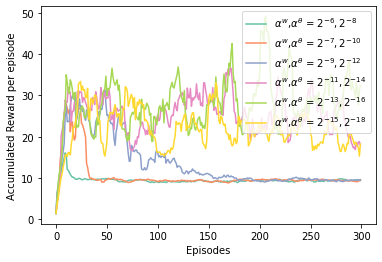

In [29]:
def main():
    GAMMA = 0.99
    EPISODES = 300
    alpha_configs = [(2**-8, 2**-6),(2**-10, 2**-7),(2**-12, 2**-9), (2**-14, 2**-11), (2**-16,2**-13), (2**-18, 2**-15)]
    env = gym.make("CartPole-v0")
    # env = gym.make("Acrobot-v1")

    cdict = plt.cm.get_cmap("Set2")
    
    
    for i, alphas in enumerate(alpha_configs):
        alpha_theta, alpha_w = alphas
       

        accumulated_rewards = one_step_actor_critic(
                              alpha_w=alpha_w, alpha_theta=alpha_theta, gamma=GAMMA,env = env, episodes=EPISODES)
        accumulated_rewards = np.array(accumulated_rewards)
        label = r"$\alpha^w$,$\alpha^\theta$ = $2^{"+str(np.log2(alpha_w).astype(np.int8))+r"}, 2^{"+str(np.log2(alpha_theta).astype(np.int8))+r"}$"
        n = 10  # the larger n is, the smoother curve will be
        b = [1.0 / n] * n
        a = 1
        smoothed_acc_rewards = lfilter(b,a,accumulated_rewards)
        
        
        # plt.plot( np.arange(len(accumulated_rewards)),accumulated_rewards, label=label, c=cdict(i), alpha=.5)
        plt.plot( np.arange(len(accumulated_rewards)),smoothed_acc_rewards, c=cdict(i), label=label)

    plt.xlabel("Episodes")
    plt.ylabel("Accumulated Reward per episode")
 
    plt.legend()
    # plt.savefig("figures/cartpole/hyperparameter_plot_cartpole_nn.png")

if __name__ == "__main__":
    main()

2e-14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 1, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 2, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 3, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 4, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 5, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 6, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 7, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 8, SUM OF REWARDS: -500.0, ACC SUM REWS -500.0
EPISODE: 9, SUM OF REWARDS: -477.0, ACC SUM REWS -497.7
EPISODE: 10, SUM OF REWARDS: -151.0, ACC SUM REWS -466.1818181818182
EPISODE: 11, SUM OF REWARDS: -175.0, ACC SUM REWS -441.9166666666667
EPISODE: 12, SUM OF REWARDS: -131.0, ACC SUM REWS -418.0
EPISODE: 13, SUM OF REWARDS: -189.0, ACC SUM REWS -401.64285714285717
EPISODE: 14, SUM OF REWARDS: -500.0, ACC SUM REWS -408.2
EPISODE: 15, SUM OF REWARDS: -500.0, ACC SUM REWS -413.9375
EPISODE: 16, SUM OF REWARDS: -500.0, ACC SUM REWS -419.0
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -431.0, ACC SUM REWS -431.0
EPISODE: 1, SUM OF REWARDS: -500.0, ACC SUM REWS -465.5
EPISODE: 2, SUM OF REWARDS: -500.0, ACC SUM REWS -477.0
EPISODE: 3, SUM OF REWARDS: -500.0, ACC SUM REWS -482.75
EPISODE: 4, SUM OF REWARDS: -500.0, ACC SUM REWS -486.2
EPISODE: 5, SUM OF REWARDS: -500.0, ACC SUM REWS -488.5
EPISODE: 6, SUM OF REWARDS: -500.0, ACC SUM REWS -490.14285714285717
EPISODE: 7, SUM OF REWARDS: -500.0, ACC SUM REWS -491.375
EPISODE: 8, SUM OF REWARDS: -500.0, ACC SUM REWS -492.3333333333333
EPISODE: 9, SUM OF REWARDS: -500.0, ACC SUM REWS -493.1
EPISODE: 10, SUM OF REWARDS: -500.0, ACC SUM REWS -493.72727272727275
EPISODE: 11, SUM OF REWARDS: -500.0, ACC SUM REWS -494.25
EPISODE: 12, SUM OF REWARDS: -472.0, ACC SUM REWS -492.53846153846155
EPISODE: 13, SUM OF REWARDS: -500.0, ACC SUM REWS -493.07142857142856
EPISODE: 14, SUM OF REWARDS: -500.0, ACC SUM REWS -493.53333333333336
EPISODE: 15, SUM OF REWARDS: -500.0, ACC SUM REWS -493.9375
EPISODE: 16, S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -313.0, ACC SUM REWS -313.0
EPISODE: 1, SUM OF REWARDS: -199.0, ACC SUM REWS -256.0
EPISODE: 2, SUM OF REWARDS: -295.0, ACC SUM REWS -269.0
EPISODE: 3, SUM OF REWARDS: -276.0, ACC SUM REWS -270.75
EPISODE: 4, SUM OF REWARDS: -215.0, ACC SUM REWS -259.6
EPISODE: 5, SUM OF REWARDS: -222.0, ACC SUM REWS -253.33333333333334
EPISODE: 6, SUM OF REWARDS: -211.0, ACC SUM REWS -247.28571428571428
EPISODE: 7, SUM OF REWARDS: -188.0, ACC SUM REWS -239.875
EPISODE: 8, SUM OF REWARDS: -218.0, ACC SUM REWS -237.44444444444446
EPISODE: 9, SUM OF REWARDS: -191.0, ACC SUM REWS -232.8
EPISODE: 10, SUM OF REWARDS: -193.0, ACC SUM REWS -229.1818181818182
EPISODE: 11, SUM OF REWARDS: -171.0, ACC SUM REWS -224.33333333333334
EPISODE: 12, SUM OF REWARDS: -150.0, ACC SUM REWS -218.6153846153846
EPISODE: 13, SUM OF REWARDS: -209.0, ACC SUM REWS -217.92857142857142
EPISODE: 14, SUM OF REWARDS: -98.0, ACC SUM REWS -209.93333333333334
EPISODE: 15, SUM OF REWARDS: -124.0, ACC SUM REWS -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -339.0, ACC SUM REWS -339.0
EPISODE: 1, SUM OF REWARDS: -500.0, ACC SUM REWS -419.5
EPISODE: 2, SUM OF REWARDS: -395.0, ACC SUM REWS -411.3333333333333
EPISODE: 3, SUM OF REWARDS: -317.0, ACC SUM REWS -387.75
EPISODE: 4, SUM OF REWARDS: -268.0, ACC SUM REWS -363.8
EPISODE: 5, SUM OF REWARDS: -195.0, ACC SUM REWS -335.6666666666667
EPISODE: 6, SUM OF REWARDS: -393.0, ACC SUM REWS -343.85714285714283
EPISODE: 7, SUM OF REWARDS: -288.0, ACC SUM REWS -336.875
EPISODE: 8, SUM OF REWARDS: -224.0, ACC SUM REWS -324.3333333333333
EPISODE: 9, SUM OF REWARDS: -283.0, ACC SUM REWS -320.2
EPISODE: 10, SUM OF REWARDS: -304.0, ACC SUM REWS -318.72727272727275
EPISODE: 11, SUM OF REWARDS: -285.0, ACC SUM REWS -315.9166666666667
EPISODE: 12, SUM OF REWARDS: -207.0, ACC SUM REWS -307.53846153846155
EPISODE: 13, SUM OF REWARDS: -216.0, ACC SUM REWS -301.0
EPISODE: 14, SUM OF REWARDS: -157.0, ACC SUM REWS -291.4
EPISODE: 15, SUM OF REWARDS: -209.0, ACC SUM REWS -286.25
EPISODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -391.0, ACC SUM REWS -391.0
EPISODE: 1, SUM OF REWARDS: -445.0, ACC SUM REWS -418.0
EPISODE: 2, SUM OF REWARDS: -345.0, ACC SUM REWS -393.6666666666667
EPISODE: 3, SUM OF REWARDS: -500.0, ACC SUM REWS -420.25
EPISODE: 4, SUM OF REWARDS: -335.0, ACC SUM REWS -403.2
EPISODE: 5, SUM OF REWARDS: -388.0, ACC SUM REWS -400.6666666666667
EPISODE: 6, SUM OF REWARDS: -401.0, ACC SUM REWS -400.7142857142857
EPISODE: 7, SUM OF REWARDS: -320.0, ACC SUM REWS -390.625
EPISODE: 8, SUM OF REWARDS: -182.0, ACC SUM REWS -367.44444444444446
EPISODE: 9, SUM OF REWARDS: -242.0, ACC SUM REWS -354.9
EPISODE: 10, SUM OF REWARDS: -335.0, ACC SUM REWS -353.09090909090907
EPISODE: 11, SUM OF REWARDS: -192.0, ACC SUM REWS -339.6666666666667
EPISODE: 12, SUM OF REWARDS: -471.0, ACC SUM REWS -349.7692307692308
EPISODE: 13, SUM OF REWARDS: -392.0, ACC SUM REWS -352.7857142857143
EPISODE: 14, SUM OF REWARDS: -264.0, ACC SUM REWS -346.8666666666667
EPISODE: 15, SUM OF REWARDS: -319.0, ACC S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPISODE: 0, SUM OF REWARDS: -379.0, ACC SUM REWS -379.0
EPISODE: 1, SUM OF REWARDS: -259.0, ACC SUM REWS -319.0
EPISODE: 2, SUM OF REWARDS: -393.0, ACC SUM REWS -343.6666666666667
EPISODE: 3, SUM OF REWARDS: -390.0, ACC SUM REWS -355.25
EPISODE: 4, SUM OF REWARDS: -305.0, ACC SUM REWS -345.2
EPISODE: 5, SUM OF REWARDS: -500.0, ACC SUM REWS -371.0
EPISODE: 6, SUM OF REWARDS: -460.0, ACC SUM REWS -383.7142857142857
EPISODE: 7, SUM OF REWARDS: -500.0, ACC SUM REWS -398.25
EPISODE: 8, SUM OF REWARDS: -493.0, ACC SUM REWS -408.77777777777777
EPISODE: 9, SUM OF REWARDS: -468.0, ACC SUM REWS -414.7
EPISODE: 10, SUM OF REWARDS: -312.0, ACC SUM REWS -405.3636363636364
EPISODE: 11, SUM OF REWARDS: -500.0, ACC SUM REWS -413.25
EPISODE: 12, SUM OF REWARDS: -485.0, ACC SUM REWS -418.7692307692308
EPISODE: 13, SUM OF REWARDS: -288.0, ACC SUM REWS -409.42857142857144
EPISODE: 14, SUM OF REWARDS: -368.0, ACC SUM REWS -406.6666666666667
EPISODE: 15, SUM OF REWARDS: -330.0, ACC SUM REWS -401.875
EPISODE

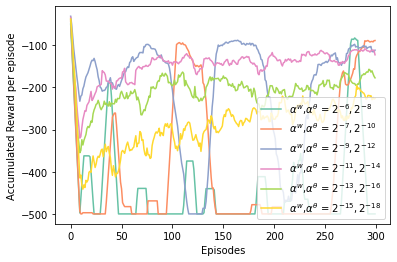

In [31]:
def main():
    GAMMA = 0.99
    EPISODES = 300
    
    alpha_configs = [(2**-8, 2**-6),(2**-10, 2**-7),(2**-12, 2**-9), (2**-14, 2**-11), (2**-16,2**-13), (2**-18, 2**-15)]
    # env = gym.make("CartPole-v0")
    env = gym.make("Acrobot-v1")
    cdict = plt.cm.get_cmap("Set2")
    
    
    for i, alphas in enumerate(alpha_configs):
        alpha_theta, alpha_w = alphas
       

        accumulated_rewards = one_step_actor_critic(
                              alpha_w=alpha_w, alpha_theta=alpha_theta, gamma=GAMMA,env = env, episodes=EPISODES)
        accumulated_rewards = np.array(accumulated_rewards)
        label = r"$\alpha^w$,$\alpha^\theta$ = $2^{"+str(np.log2(alpha_w).astype(np.int8))+r"}, 2^{"+str(np.log2(alpha_theta).astype(np.int8))+r"}$"
        n = 10  # the larger n is, the smoother curve will be
        b = [1.0 / n] * n
        a = 1
        smoothed_acc_rewards = lfilter(b,a,accumulated_rewards)
        
        
        # plt.plot( np.arange(len(accumulated_rewards)),accumulated_rewards, label=label, c=cdict(i), alpha=.5)
        plt.plot( np.arange(len(accumulated_rewards)),smoothed_acc_rewards, c=cdict(i), label=label)

    plt.xlabel("Episodes")
    plt.ylabel("Accumulated Reward per episode")
 
    plt.legend()
    # plt.savefig("figures/cartpole/hyperparameter_plot_cartpole_nn.png")

if __name__ == "__main__":
    main()